# Sentiment Analysis Pipeline for Reviews

1. Review Preprocessing
2. Sentiment Analysis
3. Exploratory Data Analysis
4. Conclusion

## 1. Preprocessing

1.	Removing duplicated rows
2.	Normalize date to year
3.	Normalize ratings to 10
4.	Drop irrelevant columns 
  - user - usernames of reviewers
-	page_url - links of where the review is scrapped from
-	date_scraped - date of when review was scrapped
-	attraction - name of attraction
5.	Lowercasing reviews
6.	Removing Emoticons, Symbols, ASCII Numbers & Punctuation (Some rows only contain emoticons or symbols)
7.	Fix slang words
8.	Stopword removal from English & Bahasa Indonesia
9.	Remove empty rows
10.	Text summarization on reviews with more than 3062 characters (Sentiment model max input of 3062)


In [1]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

def normalize_reviews(filepath):
  '''
  1. Drop duplicated rows
  2. Normalize dates to only the year
  3. Normalize ratings to 10
  '''
  
  df = pd.read_excel(filepath)
  
  # Drop duplicated rows
  df.drop_duplicates(keep='first', inplace=True)
  
  '''
  1. Normalize dates to only year
    - fix_date_week | fix_date_month | fix_date_year
      - Takes current date and minus off respective week, month or year
  '''
  
  def fix_date_week(week):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(weeks=week)
    return newdate
  
  def fix_date_month(month):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(months=month)
    return newdate
  
  def fix_date_year(year):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(years=year)
    return newdate
  
  # Replace date strings with proper year
  # Only up to 10 years
  replace_date = {'seminggu lalu': fix_date_week(1),
                  '2 minggu lalu': fix_date_week(2),
                  '3 minggu lalu': fix_date_week(3),
                  'sebulan lalu': fix_date_month(1),
                  '2 bulan lalu': fix_date_month(2),
                  '3 bulan lalu': fix_date_month(3),
                  '4 bulan lalu': fix_date_month(4),
                  '5 bulan lalu': fix_date_month(5),
                  '6 bulan lalu': fix_date_month(6),
                  '7 bulan lalu': fix_date_month(7),
                  '8 bulan lalu': fix_date_month(8),
                  '9 bulan lalu': fix_date_month(9),
                  '10 bulan lalu': fix_date_month(10),
                  '11 bulan lalu': fix_date_month(11),
                  'setahun lalu': fix_date_year(1),
                  '2 tahun lalu': fix_date_year(2),
                  '3 tahun lalu': fix_date_year(3),
                  '4 tahun lalu': fix_date_year(4),
                  '5 tahun lalu': fix_date_year(5),
                  '6 tahun lalu': fix_date_year(6),
                  '7 tahun lalu': fix_date_year(7),
                  '8 tahun lalu': fix_date_year(8),
                  '9 tahun lalu': fix_date_year(9),
                  '10 tahun lalu': fix_date_year(10),}
  
  # Split dataframe with proper datetime format
  df1 = df[df['date'].apply(lambda x: isinstance(x, datetime.date))]
  # Split dataframe with date strings
  df2 = df[df['date'].apply(lambda x: not isinstance(x, datetime.date))]
  # Replace date strings with proper year
  df2 = df2.replace({"date": replace_date})
  
  # Only extract year
  df1['date'] = pd.DatetimeIndex(df1['date']).year
  df2['date'] = pd.DatetimeIndex(df2['date']).year
  
  # Concatenate fixed year
  df = pd.concat([df1, df2], ignore_index=True)
  
  '''
  2. Normalize ratings to 10
  '''
  
  # Replace Klook ratings with 'Baik' to 8 and 'Sangat Direkomendasikan' to 10
  replace_rating = {'Baik': 8,
                  'Sangat Direkomendasikan': 10}
  df = df.replace({'rating': replace_rating})
  
  # Mask for TripAdvisor ratings
  mask = (df['source'] == 'tripadvisor')
  # Retrieve index 0 string of rating and multiply by 2
  df.loc[mask, 'rating'] = (df.loc[mask, 'rating'].str[0].astype(int))*2
  
  # Mask for Google Review ratings
  mask2 = (df['source'] == 'google_reviews')
  # Retrieve index 0 string of rating and multiply by 2
  df.loc[mask2, 'rating'] = (df.loc[mask2, 'rating'].str[14].astype(int))*2
  
  return df

In [2]:
df = normalize_reviews("../preprocess_review/raw_data/uss_master_copy.xlsx")

C:\Users\Luqman\AppData\Local\Temp\ipykernel_19076\1085505818.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.DatetimeIndex(df1['date']).year


In [3]:
# For export use later
attraction = df['attraction'][0]

In [4]:
df

,user,date,rating,review,page_url,date_scraped,source,attraction
0,mpocasino,2020,10,Universal Studio Singapore yang berada di Pula...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
1,Rudy K,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
2,Alma Jaya,2019,10,Tempat liburan keluarga yang sangat menarik un...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
3,Sri Pratiwi,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
4,Didik K,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
...,...,...,...,...,...,...,...,...
3123,Ira Wanti,2020,10,Sukses selalu Singapura,https://www.google.com/search?q=universal+stud...,4/27/2022,google_reviews,uss
3124,budi santoso,2020,10,Tempat e asyik,https://www.google.com/search?q=universal+stud...,4/27/2022,google_reviews,uss
3125,Sulastri Rahayu,2016,8,Keren bgt...♥Q sdh pernh dtng ke sana,https://www.google.com/search?q=universal+stud...,4/27/2022,google_reviews,uss
3126,Herry Sudarwanto,2019,10,Bagus,https://www.google.com/search?q=universal+stud...,4/27/2022,google_reviews,uss


In [5]:
# Drop irrelevant columns
df.drop(['user','page_url','date_scraped','attraction'], axis=1, inplace=True)

In [6]:
import pandas as pd
import ast
import string
import re

import spacy
id_nlp = spacy.blank('id')

In [7]:
def preprocess_sentiment(dataframe):
  file = open("../resources/bahasa_indonesia_slangwords.txt", "r")
  contents = file.read()
  slangwords = ast.literal_eval(contents)
  
  def tokenize_id(text):
    text_list = [token.text for i, token in enumerate(id_nlp(text))]
    return text_list
  
  def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  
  df['new_reviews'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','')
  df['new_reviews'] = df['new_reviews'].apply(lambda x: remove_emoji(x))
  df['new_reviews'] = df['new_reviews'].apply(lambda x: " ".join(slangwords.get(word, word) for word in tokenize_id(x)))
  

In [8]:
preprocess_sentiment(df)

C:\Users\Luqman\AppData\Local\Temp\ipykernel_19076\131006047.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','')


In [9]:
df

,date,rating,review,source,new_reviews
0,2020,10,Universal Studio Singapore yang berada di Pula...,tripadvisor,universal studio singapore yang berada di pula...
1,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...
2,2019,10,Tempat liburan keluarga yang sangat menarik un...,tripadvisor,tempat liburan keluarga yang sangat menarik un...
3,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,tripadvisor,beli tiketnya via ota dan kebetulan sudah prin...
4,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",tripadvisor,jalan jalan bareng si kecil emang menyenangkan...
...,...,...,...,...,...
3123,2020,10,Sukses selalu Singapura,google_reviews,sukses selalu singapura
3124,2020,10,Tempat e asyik,google_reviews,tempat e asyik
3125,2016,8,Keren bgt...♥Q sdh pernh dtng ke sana,google_reviews,keren bgtq sdh pernh dtng ke sana
3126,2019,10,Bagus,google_reviews,bagus


In [10]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [11]:
eng_stopwords = set(line.strip() for line in open('../resources/stop_words_english.txt', encoding='utf-8'))
id_stopwords = set(line.strip() for line in open('../resources/stop_words_bahasaindonesia.txt', encoding='utf-8'))
new_stopwords = eng_stopwords.union(id_stopwords)
# Add new set of stopwords into spacy stopword list
nlp.Defaults.stop_words |= new_stopwords

In [12]:
df['remove_stop'] = df.new_reviews.apply(lambda text: 
                                          " ".join(token.text for token in nlp(text) 
                                                   if not token.is_stop))

In [13]:
df = df[['date', 'rating', 'source', 'review', 'new_reviews', 'remove_stop']]

In [14]:
df

,date,rating,source,review,new_reviews,remove_stop
0,2020,10,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore yang berada di pula...,universal studio singapore pulau sentosa singa...
1,2019,10,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,cukup beruntung hanya membeli tiket biasa dapa...,beruntung membeli tiket mengikuti hampir aktra...
2,2019,10,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,tempat liburan keluarga yang sangat menarik un...,liburan keluarga menarik dikunjungi sarana rek...
3,2020,10,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiketnya via ota dan kebetulan sudah prin...,beli tiketnya ota print rumah uss tunjukan pet...
4,2020,10,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil emang menyenangkan...,jalan jalan bareng si kecil menyenangkan bagus...
...,...,...,...,...,...,...
3123,2020,10,google_reviews,Sukses selalu Singapura,sukses selalu singapura,sukses singapura
3124,2020,10,google_reviews,Tempat e asyik,tempat e asyik,e asyik
3125,2016,8,google_reviews,Keren bgt...♥Q sdh pernh dtng ke sana,keren bgtq sdh pernh dtng ke sana,keren bgtq sdh pernh dtng
3126,2019,10,google_reviews,Bagus,bagus,bagus


In [15]:
# Remove empty rows
df = df[df['remove_stop'].str.strip().astype(bool)]
df

,date,rating,source,review,new_reviews,remove_stop
0,2020,10,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore yang berada di pula...,universal studio singapore pulau sentosa singa...
1,2019,10,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,cukup beruntung hanya membeli tiket biasa dapa...,beruntung membeli tiket mengikuti hampir aktra...
2,2019,10,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,tempat liburan keluarga yang sangat menarik un...,liburan keluarga menarik dikunjungi sarana rek...
3,2020,10,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiketnya via ota dan kebetulan sudah prin...,beli tiketnya ota print rumah uss tunjukan pet...
4,2020,10,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil emang menyenangkan...,jalan jalan bareng si kecil menyenangkan bagus...
...,...,...,...,...,...,...
3123,2020,10,google_reviews,Sukses selalu Singapura,sukses selalu singapura,sukses singapura
3124,2020,10,google_reviews,Tempat e asyik,tempat e asyik,e asyik
3125,2016,8,google_reviews,Keren bgt...♥Q sdh pernh dtng ke sana,keren bgtq sdh pernh dtng ke sana,keren bgtq sdh pernh dtng
3126,2019,10,google_reviews,Bagus,bagus,bagus


## Text Summarization
- Summarize reviews more than 3062 characters

In [16]:
from transformers import pipeline

In [17]:
summary_model = pipeline("summarization",
              model="cahya/t5-base-indonesian-summarization-cased",
              tokenizer="cahya/t5-base-indonesian-summarization-cased")

In [18]:
mask = (df['remove_stop'].str.len() >= 3062)
df.loc[mask, 'remove_stop'] = df.loc[mask, 'remove_stop'].apply(lambda x: summary_model(x, max_length=600)[0]['summary_text']).str.replace('[^\w\s]','')

C:\Users\Luqman\AppData\Local\Temp\ipykernel_19076\2678385910.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[mask, 'remove_stop'] = df.loc[mask, 'remove_stop'].apply(lambda x: summary_model(x, max_length=600)[0]['summary_text']).str.replace('[^\w\s]','')


## Sentiment Analysis

In [19]:
from transformers import pipeline
import sentencepiece
import transformers

In [20]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa",
    tokenizer="ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa"
)

In [21]:
def get_sentiment(text):
    prediction = sentiment_model(text)[0]['label']
    return prediction

In [22]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [23]:
df['sentiment'] = df['remove_stop'].progress_apply(get_sentiment)

  0%|          | 0/3107 [00:00<?, ?it/s]

C:\Users\Luqman\AppData\Local\Temp\ipykernel_19076\3649406064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['remove_stop'].progress_apply(get_sentiment)


In [24]:
df = df[['date', 'source', 'review', 'new_reviews', 'remove_stop', 'rating', 'sentiment']]
df

,date,source,review,new_reviews,remove_stop,rating,sentiment
0,2020,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore yang berada di pula...,universal studio singapore pulau sentosa singa...,10,Neutral
1,2019,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,cukup beruntung hanya membeli tiket biasa dapa...,beruntung membeli tiket mengikuti hampir aktra...,10,Neutral
2,2019,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,tempat liburan keluarga yang sangat menarik un...,liburan keluarga menarik dikunjungi sarana rek...,10,Positive
3,2020,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiketnya via ota dan kebetulan sudah prin...,beli tiketnya ota print rumah uss tunjukan pet...,10,Neutral
4,2020,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil emang menyenangkan...,jalan jalan bareng si kecil menyenangkan bagus...,10,Positive
...,...,...,...,...,...,...,...
3123,2020,google_reviews,Sukses selalu Singapura,sukses selalu singapura,sukses singapura,10,Positive
3124,2020,google_reviews,Tempat e asyik,tempat e asyik,e asyik,10,Positive
3125,2016,google_reviews,Keren bgt...♥Q sdh pernh dtng ke sana,keren bgtq sdh pernh dtng ke sana,keren bgtq sdh pernh dtng,8,Positive
3126,2019,google_reviews,Bagus,bagus,bagus,10,Positive


In [104]:
# Add Length and Word Count 
df['review_len'] = df['remove_stop'].astype(str).apply(len)
df['word_count'] = df['remove_stop'].apply(lambda x: len(str(x).split()))

C:\Users\Luqman\AppData\Local\Temp\ipykernel_19076\496550493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_len'] = df['remove_stop'].astype(str).apply(len)
C:\Users\Luqman\AppData\Local\Temp\ipykernel_19076\496550493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['remove_stop'].apply(lambda x: len(str(x).split()))


In [105]:
# Export data
df.to_excel('uss_sentiment.xlsx', index=False)

## Analysis & Visualization

- Review Rating Distribution
- Review Length Distribution
- Review Word Count Distribution
- Ratings vs. Sentiment
- Sentiment Share Overall
- Word Cloud
- Top Word Frequency
- Top 15 Words For Positive Sentiment
- Top 15 Words For Neutral Sentiment
- Top 15 Words For Negative Sentiment

**TODO**
- Review length based on ratings
- Review length based on sentiment

In [72]:
df.groupby(['rating'])['remove_stop'].count()

rating
2        3
4       11
5       14
6      112
8      780
9      331
10    1856
Name: remove_stop, dtype: int64

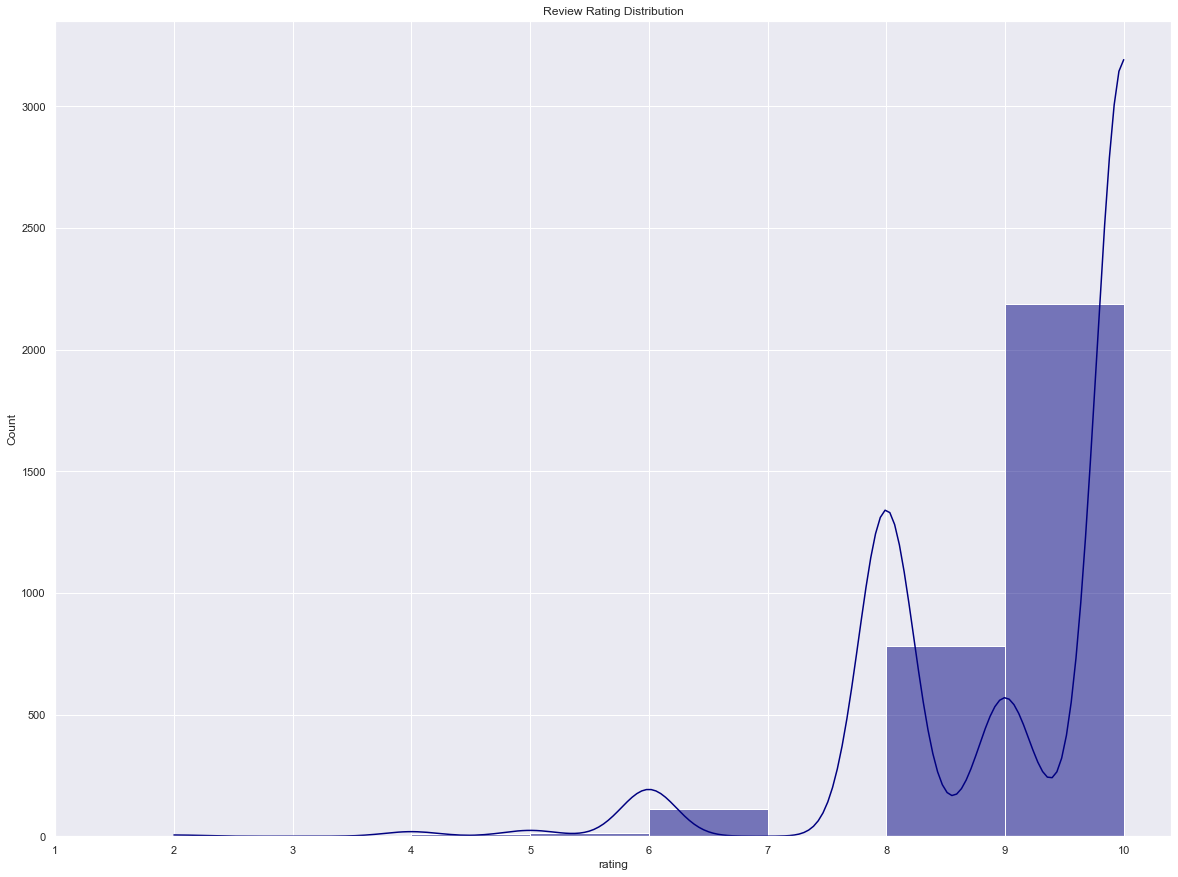

In [103]:
ratings_dist = sns.histplot(
    data=df,
    x="rating",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.xticks(range(1,11))
plt.title("Review Rating Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### The distribution of review text lengths

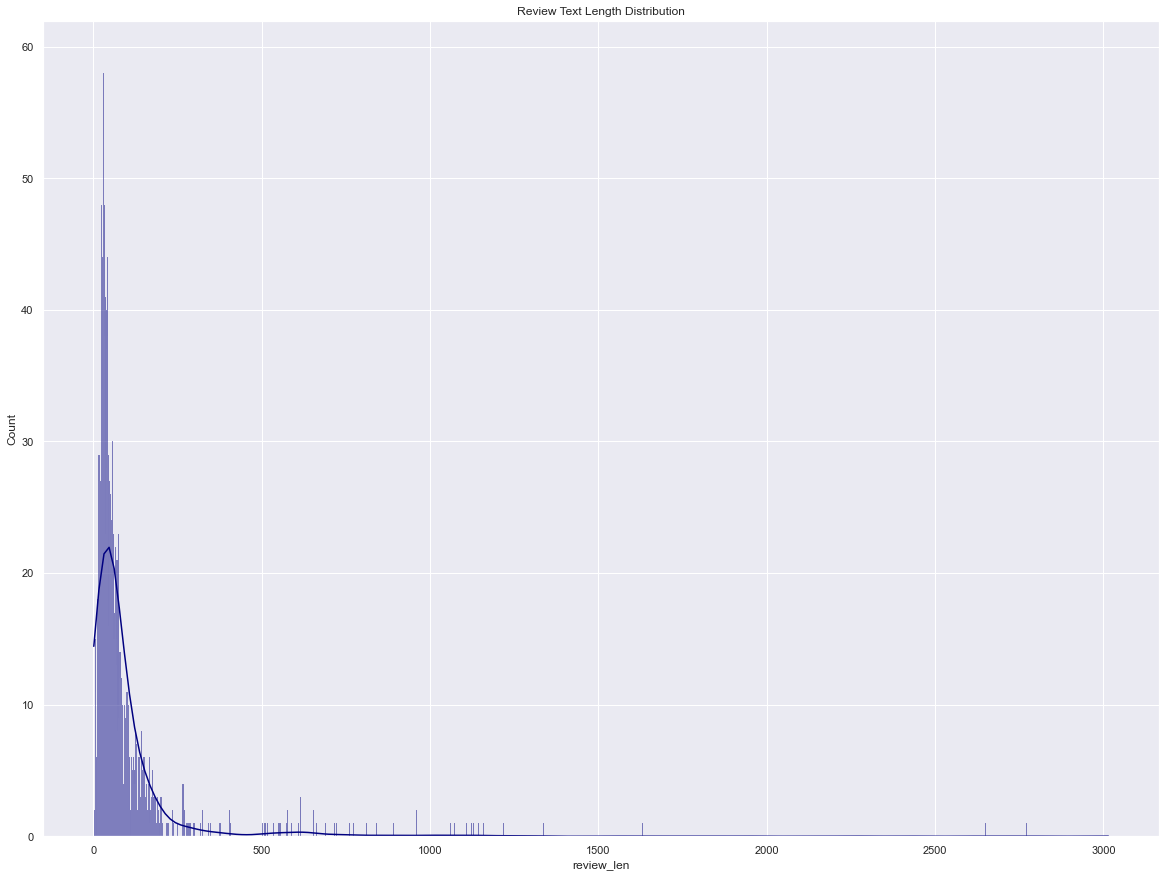

In [107]:
review_length_dist = sns.histplot(
    data=df,
    x="review_len",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.title("Review Text Length Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### The distribution of review word count

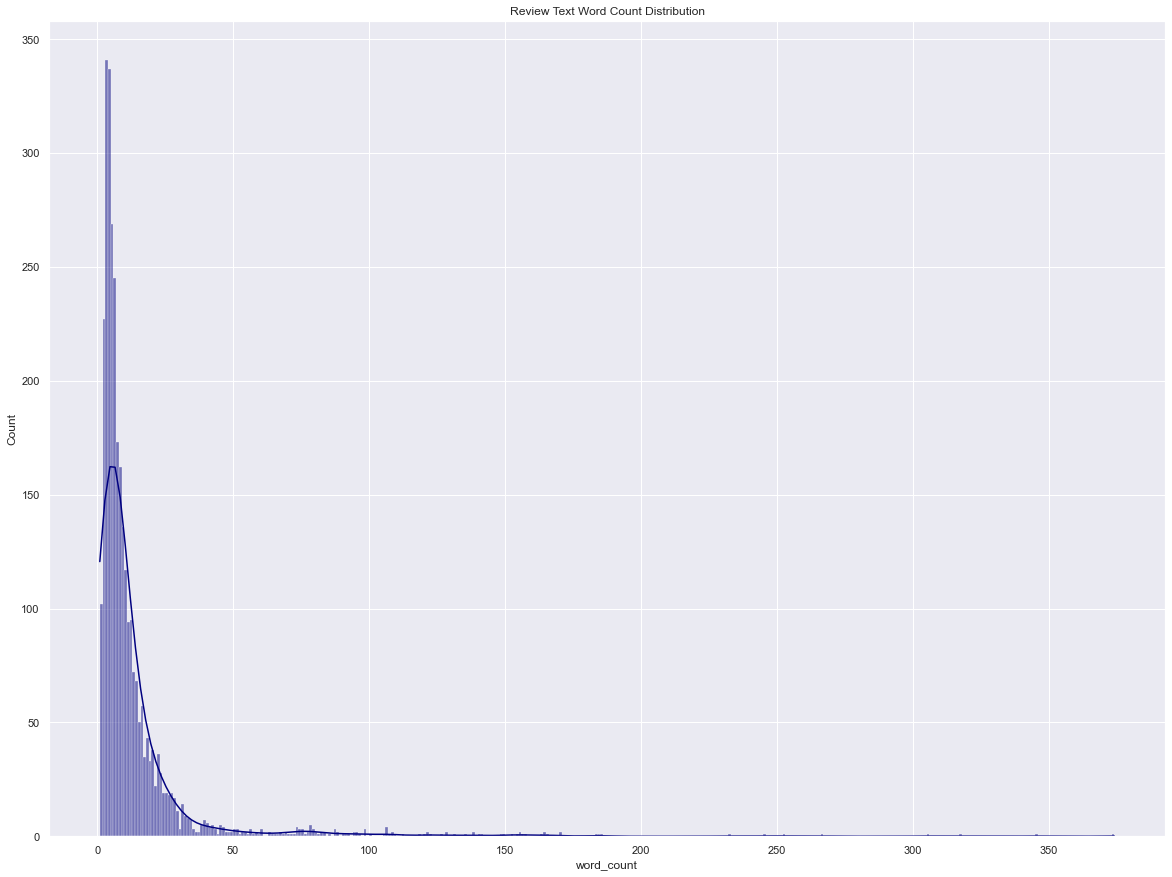

In [108]:
review_length_dist = sns.histplot(
    data=df,
    x="word_count",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.title("Review Text Word Count Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

In [27]:
df.groupby(['rating','sentiment'])['remove_stop'].count()

rating  sentiment
2       Negative        1
        Neutral         1
        Positive        1
4       Negative        4
        Neutral         1
        Positive        6
5       Negative        8
        Neutral         4
        Positive        2
6       Negative       27
        Neutral        34
        Positive       51
8       Negative       76
        Neutral       157
        Positive      547
9       Negative       19
        Neutral        62
        Positive      250
10      Negative      136
        Neutral       298
        Positive     1422
Name: remove_stop, dtype: int64

### Ratings vs. Sentiment

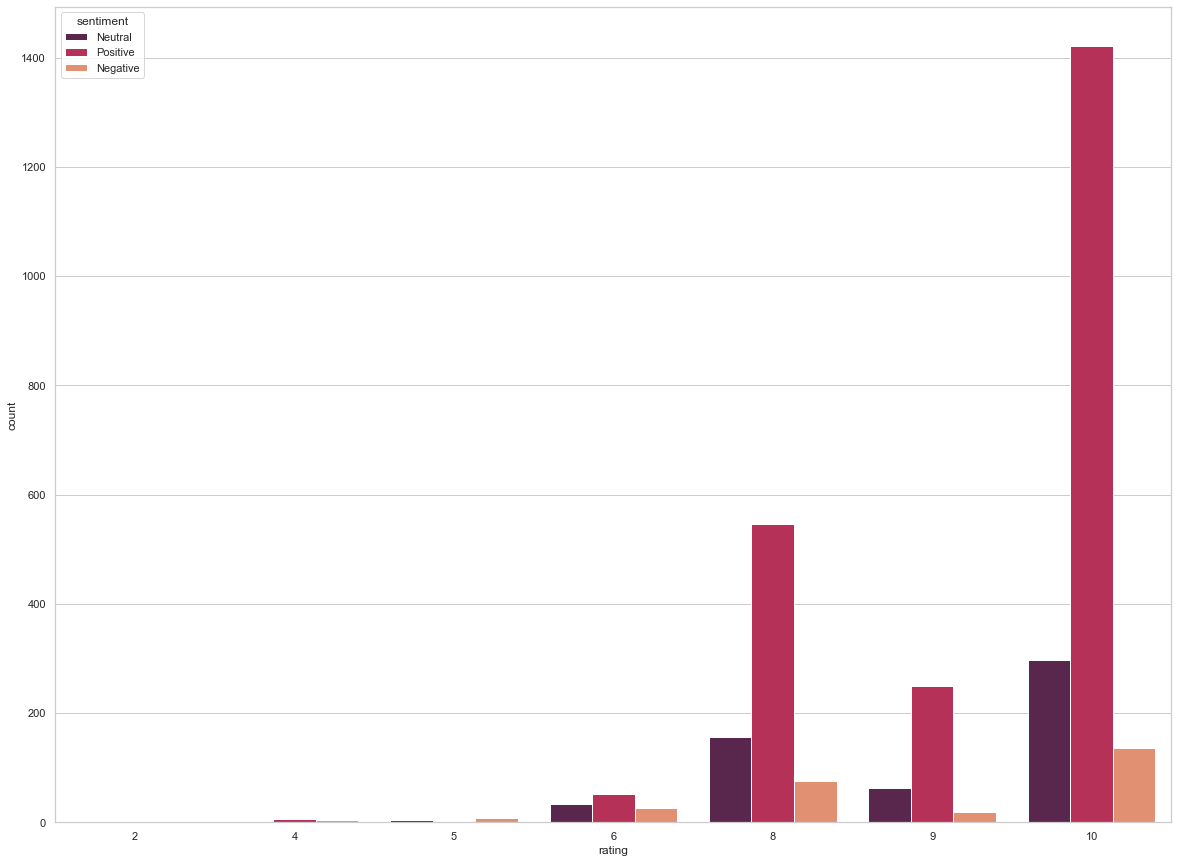

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

rating_vs_sentiment = sns.countplot(
    data=df,
    x="rating", hue="sentiment", palette="rocket",
)
sns.set_theme(rc={'figure.figsize':(20,15)})

### Sentiment Share for USS Attraction

<AxesSubplot:ylabel='remove_stop'>

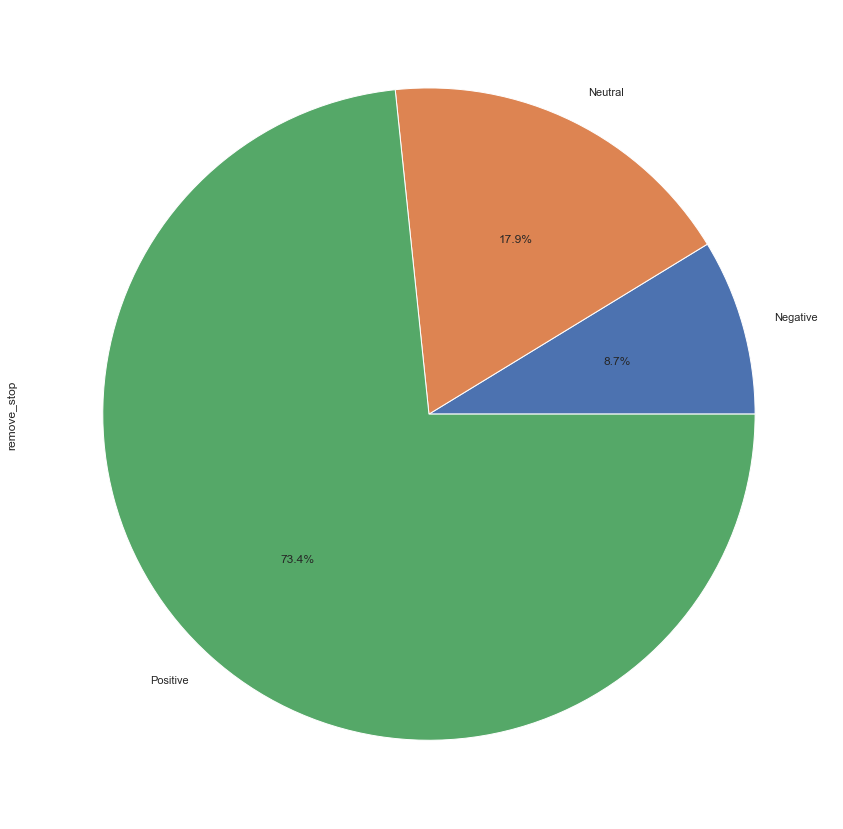

In [41]:
sentiment_share_overall = df.groupby('sentiment')['remove_stop'].count()
sentiment_share_overall.plot.pie(autopct="%.1f%%")

### Word Cloud

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):

    wordcloud = WordCloud(
        width=1600, 
        height=800,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

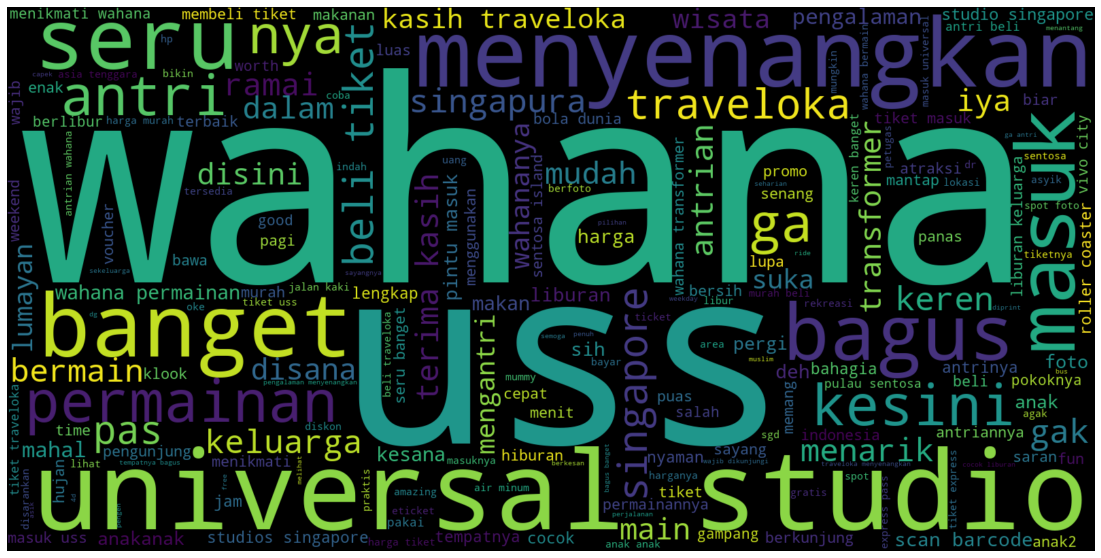

In [49]:
text = " ".join(i for i in df.remove_stop)
wordcloud = WordCloud(width=1600, height=800).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")

plt.show()

### Top 15 Words Overall

In [71]:
word_count = WordCloud().process_text(text)
word_count = pd.DataFrame(word_count.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
word_count.head(15)

,word,frequency
5,wahana,571
29,uss,441
4613,universal studio,396
50,menyenangkan,360
74,banget,305
70,seru,290
34,masuk,269
51,bagus,244
59,permainan,219
67,kesini,207


### Top Words in Positive Sentiment

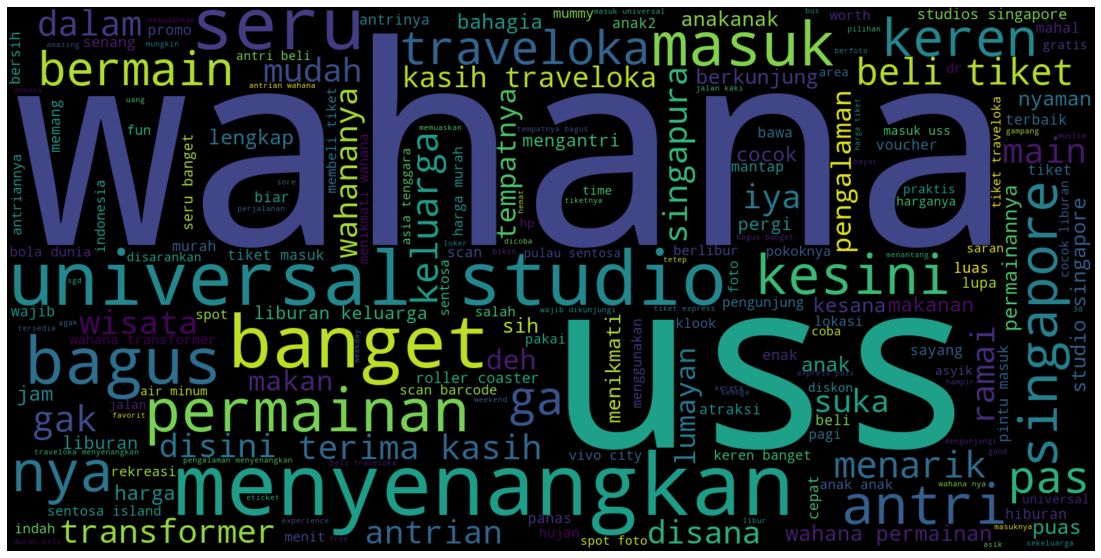

In [130]:
mask = (df['sentiment'] == 'Positive')
pos_df = df[mask]

pos_text = " ".join(i for i in pos_df.remove_stop)
pos_wordcloud = WordCloud(width=1600, height=800).generate(pos_text)

plt.figure(figsize=[20,10])
plt.imshow(pos_wordcloud,interpolation='bilinear')
plt.axis("off")

plt.show()

In [131]:
pos_wordcount = WordCloud().process_text(pos_text)
pos_wordcount = pd.DataFrame(pos_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
pos_wordcount.head(15)

,word,frequency
21,wahana,521
186,uss,371
10,menyenangkan,356
3749,universal studio,300
38,banget,286
34,seru,278
11,bagus,228
104,masuk,199
22,permainan,188
180,nya,167


### Top Words in Neutral Sentiment

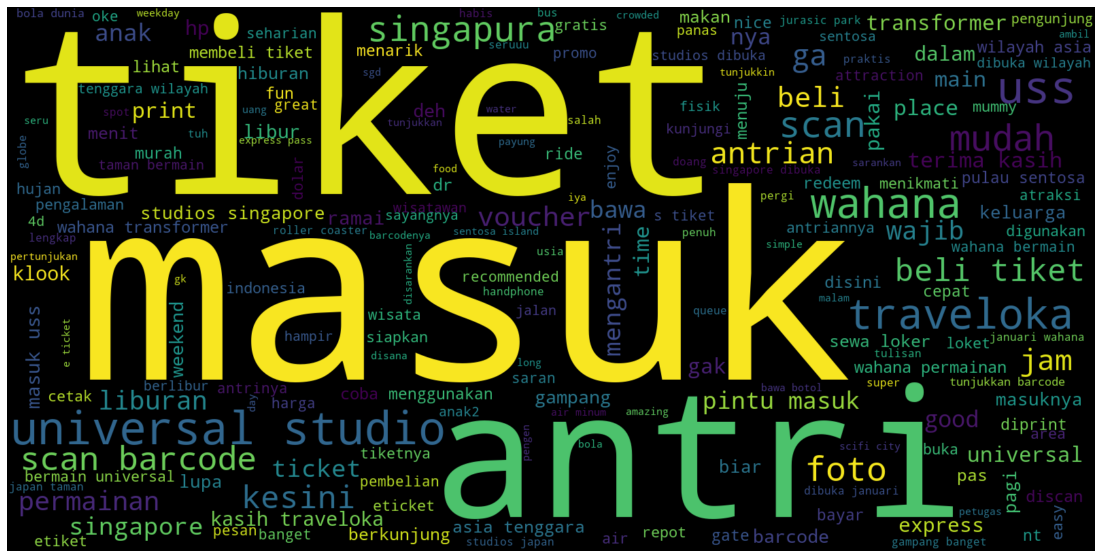

In [133]:
mask = (df['sentiment'] == 'Neutral')
neu_df = df[mask]

neu_text = " ".join(i for i in neu_df.remove_stop)
neu_wordcloud = WordCloud(width=1600, height=800).generate(neu_text)

plt.figure(figsize=[20,10])
plt.imshow(neu_wordcloud,interpolation='bilinear')
plt.axis("off")

plt.show()

In [134]:
neu_wordcount = WordCloud().process_text(neu_text)
neu_wordcount = pd.DataFrame(neu_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
neu_wordcount.head(15)

,word,frequency
26,masuk,113
7,tiket,95
63,antri,81
1453,universal studio,81
21,uss,77
371,traveloka,70
4,wahana,69
234,scan,48
254,mudah,46
3,singapura,44


### Top Words in Negative Sentiment

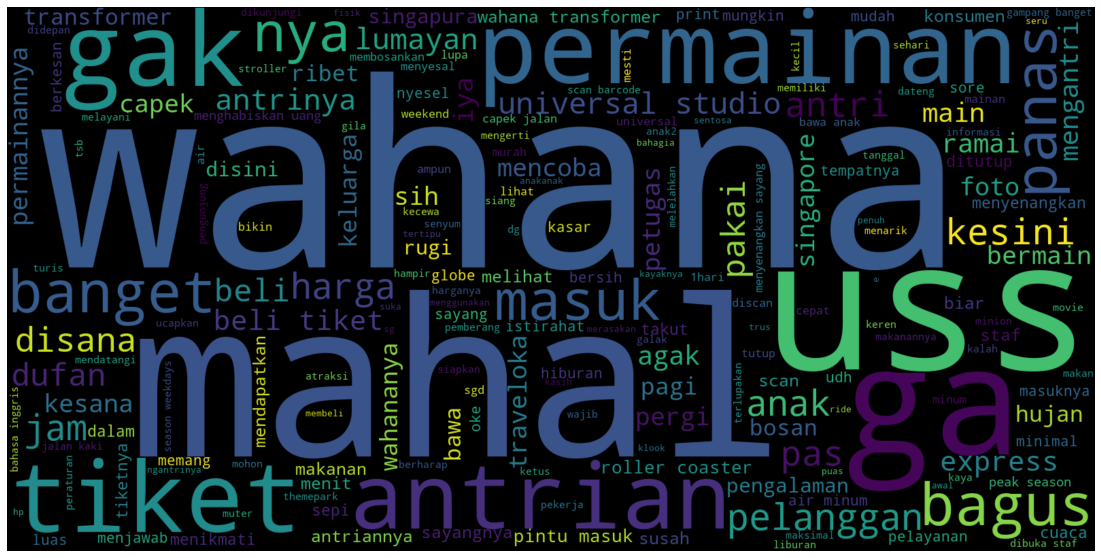

In [135]:
mask = (df['sentiment'] == 'Negative')
neg_df = df[mask]

neg_text = " ".join(i for i in neg_df.remove_stop)
neg_wordcloud = WordCloud(width=1600, height=800).generate(neg_text)

plt.figure(figsize=[20,10])
plt.imshow(neg_wordcloud,interpolation='bilinear')
plt.axis("off")

plt.show()

In [136]:
neg_wordcount = WordCloud().process_text(neg_text)
neg_wordcount = pd.DataFrame(neg_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
neg_wordcount.head(15)

,word,frequency
73,wahana,67
58,mahal,47
53,uss,44
6,ga,33
131,permainan,30
83,gak,30
18,tiket,29
313,panas,25
70,antrian,25
309,bagus,25
